In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm

### Set up HF

In [2]:
# Imports the client side code for interfacing with the HF API
from lib.hf_client import HFClient

In [3]:
api_key = os.getenv("HF_API_KEY")
org = os.getenv("HF_ORG")

hf_client = HFClient(api_key, org, use_tqdm=True, kill_endpoint_on_exit=False)

### Models

In [4]:
MODELS = {
    "meta-llama/Meta-Llama-3-70B": "Llama 3 70b",
    "meta-llama/Meta-Llama-3-8B": "Llama 3 8b",
    "meta-llama/Meta-Llama-3-8B-Instruct": "Llama 3 8b instruct",
    "meta-llama/Llama-3.1-70B": "Llama 3.1 70b",
    "mistralai/Mixtral-8x7B-v0.1": "Mixtral 8x7b",
    "mistralai/Mixtral-8x22B-v0.1": "Mixtral 8x22b",
    # "EleutherAI/pythia-6.9b": "Pythia 6.9B",
    # "EleutherAI/pythia-12b": "Pythia 12B"
}

In [5]:
# selected_model = "meta-llama/Meta-Llama-3-8B-Instruct"
selected_model = "meta-llama/Meta-Llama-3-70B"

if selected_model not in MODELS:
    selected_model = None
    raise ValueError(f"Model {selected_model} not found in MODELS")

In [6]:
selected_model

'meta-llama/Meta-Llama-3-70B'

In [7]:
hf_client.wait_for_model(selected_model)

In [8]:
selected_model

'meta-llama/Meta-Llama-3-70B'

### Load dataset

In [9]:
df_fb = pd.read_csv("data/raw/fb.csv")

### Set up task

In [12]:
def get_logprob(passage, location):

    final_passage = passage + location
    response = hf_client.send_prompt(final_passage, max_new_tokens=1)

    return response[0]['details']['prefill'][-1]

results = []
#### EXAMKPLE
for index, row in df_fb[0:2].iterrows():
    
    passage = row['passage'].replace("[MASK].", "")
    start_location = row['start'] if passage.endswith(" ") else " " + row['start']
    end_location = row['end'] if passage.endswith(" ") else " " + row['end']
    
    lp_start_response = get_logprob(passage, start_location)
    lp_end_response = get_logprob(passage, end_location)

    lp_start = lp_start_response['logprob']
    lp_end = lp_end_response['logprob']

    results.append({
        'lp_start': lp_start,
        'lp_end': lp_start,
        'passage': row['passage'],
        'start': row['start'],
        'end': row['end'],
        'knowledge_cue': row['knowledge_cue'],
        'first_mention': row['first_mention'],
        'recent_mention': row['recent_mention'],
        'log_odds': lp_start - lp_end,
        'condition': row['condition']
    })



In [13]:
results = []
with tqdm(total=df_fb.shape[0]) as pbar:    
    for index, row in df_fb.iterrows():
        
        passage = row['passage'].replace("[MASK].", "")
        start_location = row['start'] if passage.endswith(" ") else " " + row['start']
        end_location = row['end'] if passage.endswith(" ") else " " + row['end']
        
        lp_start_response = get_logprob(passage, start_location)
        lp_end_response = get_logprob(passage, end_location)
    
        lp_start = lp_start_response['logprob']
        lp_end = lp_end_response['logprob']
    
        results.append({
            'lp_start': lp_start,
            'lp_end': lp_start,
            'passage': row['passage'],
            'start': row['start'],
            'end': row['end'],
            'knowledge_cue': row['knowledge_cue'],
            'first_mention': row['first_mention'],
            'recent_mention': row['recent_mention'],
            'log_odds': lp_start - lp_end,
            'condition': row['condition']
        })


        pbar.update(1)

 37%|███████████████▌                          | 71/192 [01:19<02:16,  1.13s/it]


KeyboardInterrupt: 

In [14]:
df_results = pd.DataFrame(results)

<Axes: xlabel='knowledge_cue', ylabel='log_odds'>

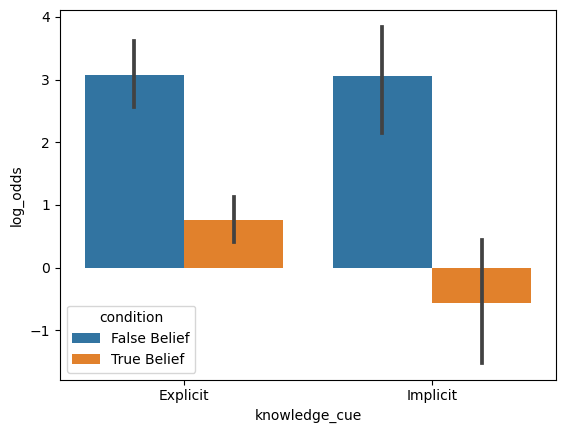

In [15]:
sns.barplot(data = df_results, x = "knowledge_cue", y = "log_odds", hue = "condition")

In [ ]:
def calculate_accuracy(row):
    if row['condition'] == 'False Belief':
        return row['log_odds'] > 0
    else:
        return row['log_odds'] < 0

In [15]:
df_results['correct'] = df_results.apply(calculate_accuracy, axis = 1)

In [16]:
df_results['correct'].mean()

0.78125

In [32]:
import sys

In [33]:
sys.executable

'/Users/seantrott/anaconda3/bin/python'